In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

In [2]:
mypathNonBird ='./Xeno_canto/Xeno-canto-Google_AudioSet/*/*.wav'
mypathBird ='./Xeno_canto/Xeno-canto-Google_AudioSet/Bird/*/*.wav'

In [3]:
import glob
fileNameNonBird = glob.glob(mypathNonBird)
nonBirdLabel = ['n'] * len(fileNameNonBird)
fileNameBird = glob.glob(mypathBird)
birdLabel = ['y'] * len(fileNameBird)

In [4]:
xeno_canto = fileNameNonBird + fileNameBird
xeno_canto_label = nonBirdLabel + birdLabel
result = list(zip(xeno_canto, xeno_canto_label))
result = list(map(list, result))

In [5]:
df = pd.DataFrame(result, columns=['Filename', 'Bird(s)?'])
df['Bird(s)?'].value_counts()

n    5163
y    4674
Name: Bird(s)?, dtype: int64

## NIPS4B dataset

In [ ]:
df_nips4b = pd.read_csv('NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/nips4b_birdchallenge_train_labels.csv')
df_nips4b = df_nips4b.drop('Unnamed: 3', 1)
df_nips4b = df_nips4b.drop('Unnamed: 1', 1)
df_nips4b.fillna(0, inplace=True)

In [ ]:
a = df_nips4b.iloc[1,:2].values
b = df_nips4b.iloc[0,2:].values
c = np.concatenate((a, b), axis=0)
columns = c[1:]

df_nips4b = df_nips4b.drop([0,1,689])
df_nips4b.reset_index(inplace=True)
df_nips4b = df_nips4b.drop('index', 1)
df_nips4b.columns = c

In [ ]:
df_nips4b.Filename = ['./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/'+f for f in df_nips4b.Filename]
df_nips4b

In [ ]:
cols=[i for i in df_nips4b.columns if i not in ["Filename"]]
for col in cols:
    df_nips4b[col]=pd.to_numeric(df_nips4b[col])
    
# helper function for displaying a sample as an image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

In [ ]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df_nips4b[['Empty']].values)
nips4b = pd.DataFrame(index=df_nips4b['Filename'],data=one_hot_labels,columns=classes)
nips4b.rename(columns={0: "non-empty", 1: "empty"}, inplace=True)
nips4b['empty'].value_counts()

In [ ]:
nips4b

In [ ]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df[['Bird(s)?']].values)
test_data = pd.DataFrame(index=df['Filename'],data=one_hot_labels,columns=classes)
test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)

In [ ]:
test_data = test_data[['non-empty', 'empty']]
test_data

In [ ]:
test_data['empty'].value_counts()

In [ ]:
cols=[i for i in test_data.columns if i not in ["Filename"]]
for col in cols:
    test_data[col]=pd.to_numeric(test_data[col])
test_data.shape

In [ ]:
df = test_data.append(nips4b)
df

In [ ]:
from sklearn.model_selection import train_test_split

train_df,valid_df = train_test_split(df,test_size=0.2,random_state=1)

In [ ]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df)
train_dataset.actions.load_audio.set(sample_rate=44100)
train_dataset.augmentation_on()

valid_dataset = CnnPreprocessor(valid_df)
valid_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset.augmentation_on()

In [ ]:
train_dataset.actions.load_audio.params

In [ ]:
# Create model object
classes = train_df.columns
model = cnn.PytorchModel('resnet18',classes,single_target=True)

In [ ]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./nips_xeno_canto_train_augmentation_on/',
    epochs=12,
    batch_size=64,
    save_interval=100,
    num_workers=2,
)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [6]:
# ==================== model trained on nips4B dataset ======================
from opensoundscape.torch.models.cnn import load_model
model = load_model('./nips_xeno_canto_train_augmentation_on/best.model')

## Peru Dataset

In [7]:
df_test = pd.read_csv('peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/Copy of Stratified_Random_Sample_Bird_Labels.csv')

df_test['Filename'] = './peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/' + df_test['Folder'] + '/' + df_test['Clip']
df_test.drop(columns=['Folder', 'Clip'], inplace=True)

from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df_test[['Bird(s)?']].values)
test_data = pd.DataFrame(index=df_test['Filename'],data=one_hot_labels,columns=classes)
print(test_data.head())
test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)

test_data = test_data[['non-empty', 'empty']]

cols=[i for i in test_data.columns if i not in ["file"]]
for col in cols:
    test_data[col]=pd.to_numeric(test_data[col])

                                                    n  y
Filename                                                
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  1  0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  1  0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1


In [8]:
#create a copy of the training dataset, sampling 0 of the training samples from it
prediction_dataset = model.train_dataset.sample(n=0)
#turn off augmentation on this dataset
prediction_dataset.augmentation_off()
#use the validation samples as test samples for the sake of illustration
prediction_dataset.df = test_data

In [9]:
prediction_dataset.df

,non-empty,empty
Filename,,
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_5.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_13.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D28A2C8_0.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_10.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_8.WAV,1,0
...,...,...
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190627_151000_12.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190701_084000_1.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190624_074000_14.WAV,0,1


In [10]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 activation_layer='softmax')
valid_scores_df

(7120, 2)


,non-empty,empty
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_5.WAV,0.999985,0.000015
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_13.WAV,0.966746,0.033254
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D28A2C8_0.WAV,0.999934,0.000066
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_10.WAV,0.852672,0.147328
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_8.WAV,0.999977,0.000023
...,...,...
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190627_151000_12.WAV,0.999997,0.000003
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190701_084000_1.WAV,0.999880,0.000120
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190624_074000_14.WAV,0.980086,0.019914
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190621_085000_19.WAV,0.998278,0.001722


In [11]:
valid_labels_df

,non-empty,empty
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_5.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_13.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D28A2C8_0.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D208AE8_10.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/WWF5_samples_split/5D2C0D00_8.WAV,1,0
...,...,...
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190627_151000_12.WAV,1,0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190701_084000_1.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190624_074000_14.WAV,0,1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/AM1_samples_split/20190621_085000_19.WAV,0,1


In [12]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.44      1.00      0.61      3113
           1       1.00      0.00      0.00      4007

   micro avg       0.44      0.44      0.44      7120
   macro avg       0.72      0.50      0.30      7120
weighted avg       0.75      0.44      0.27      7120
 samples avg       0.44      0.44      0.44      7120



In [13]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] 

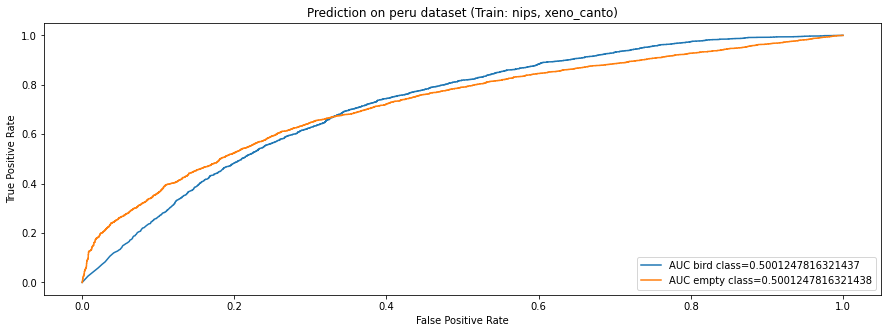

In [15]:
fpr, tpr, thresh = roc_curve(valid_labels_df['non-empty'],  valid_scores_df['non-empty'])
auc = roc_auc_score(valid_labels_df['non-empty'],  valid_preds_df['non-empty'])

fpr2, tpr2, thresh2 = roc_curve(valid_labels_df['empty'],  valid_scores_df['empty'])
auc2 = roc_auc_score(valid_labels_df['empty'],  valid_preds_df['empty'])

#create ROC curve
plt.plot(fpr,tpr,label="AUC bird class="+str(auc))
plt.title('Prediction on peru dataset (Train: nips, xeno_canto)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr2,tpr2,label="AUC empty class="+str(auc2))
plt.legend(loc=4)
plt.savefig('./nips_xeno_canto_train_augmentation_on/model_AUC_nips_xeno_peru_aug.jpg', format='jpg', transparent=False)